In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import pandas as pd
import numpy as np

import glob 
import math

import torch # For building the networks 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import Adam
import torch.optim as optim
import torch.nn.functional as F
from nystrom_attention import NystromAttention

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score
from lifelines.utils import concordance_index
# import torchvision.transforms as transforms
from PIL import Image

# from TCGA_preprocess import TCGA_csv_process\
import sys

#Feature extraction
# from utils import perform_clustering, select_representative_images, extract_features
# import torchvision.models as models
import openslide as op
import cv2

import h5py
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def neg_par_log_likelihood(pred,ytime,yevent):
    n_observed = yevent.sum(0)
    if(n_observed==0):
        return 0.0
    
    ytime_indicator = R_set(ytime).float()
    
    if torch.cuda.is_available():
        ytime_indicator = ytime_indicator.cuda()
    # pred = torch.tensor(pred.values).cuda()
    
    risk_set_sum = ytime_indicator.mm(torch.exp(pred.float()))
    
    diff = pred - torch.log(risk_set_sum)
    
    yevent = yevent[:,None]
    
    sum_diff_in_observed = torch.transpose(diff,0,1).mm(yevent.float())
    
    cost = (- (sum_diff_in_observed / n_observed)).reshape((-1,))
    
    return cost
#https://github.com/tomcat123a/survival_loss_criteria/blob/master/loss.py
def R_set(x):
	'''Create an indicator matrix of risk sets, where T_j >= T_i.
	Note that the input data have been sorted in descending order.
	Input:
		x: a PyTorch tensor that the number of rows is equal to the number of samples.
	Output:
		indicator_matrix: an indicator matrix (which is a lower traiangular portions of matrix).
	'''
  
	n_sample = x.size(0)
	matrix_ones = torch.ones(n_sample, n_sample)
	indicator_matrix = torch.triu(matrix_ones)
    

	return(indicator_matrix)
    
# Define your custom dataset class
class SurvivalDataset(Dataset):
    def __init__(self, feat_paths, surv_data, clinical_data, num_patches = 10000, transform=None, mtlr = True):
        '''
        surv_data : ('TCGA-44-6777', 987.0, 1.0) [patient id, OS.time, OS]

        num_patch : int (>=50)
        '''
        self.feat_paths = feat_paths
        self.survival_data = surv_data
        self.clinical_data = clinical_data
        self.transform = transform
        
        self.mtlr = mtlr
        # self.cancer_classifier = cancer_classifier
    def __len__(self):
        return len(self.feat_paths)

    def __getitem__(self, idx):
        #max_num_patches = 144501
        desired_shape = (10000, 512)
       
        patches = torch.load(self.feat_paths[idx])
     
        if patches.shape[0] < desired_shape[0]:
            # If the tensor has more rows than the desired shape, pad it with zeros
            padding_needed = desired_shape[0] - patches.shape[0]
            patches = torch.nn.functional.pad(patches, (0, 0, 0, padding_needed))
        else:
            # Shuffle the indices
            shuffled_indices = torch.randperm(patches.size(0))
            
            # Use the shuffled indices to rearrange the rows of the tensor
            patches = patches[shuffled_indices][:desired_shape[0]]
                
        event = self.survival_data[idx][3]
        time = self.survival_data[idx][1]
        
        if self.mtlr:
            time_val = self.survival_data[idx][2]
            time = np.array(time, dtype=np.float32)
            time = torch.tensor(time, dtype=torch.float32)
            
         # Convert clinical_data to a numpy array with float type
        clinical_data = np.array(self.clinical_data[idx], dtype=np.float32)
        
        # Convert the numpy array to a PyTorch tensor
        clinical_data = torch.tensor(clinical_data, dtype=torch.float32)
        
        return patches, time, event, clinical_data, time_val



In [2]:
# !pip install lifelines
# !pip install nystrom-attention
# !pip install sklearn-pandas

In [4]:

class TransLayer(nn.Module):

    def __init__(self, norm_layer=nn.LayerNorm, dim=512):
        super().__init__()
        self.norm = norm_layer(dim)
        self.attn = NystromAttention(
            dim = dim,
            dim_head = dim//8, #8
            heads = 2, #8
            num_landmarks = dim//2,    # number of landmarks
            pinv_iterations = 6,    # number of moore-penrose iterations for approximating pinverse. 6 was recommended by the paper
            residual = True,         # whether to do an extra residual with the value or not. supposedly faster convergence if turned on
            dropout=0.1
        )

    def forward(self, x):
        a = self.attn(self.norm(x))
        x= x + a

        return x, None


class PPEG(nn.Module):
    def __init__(self, dim=512):
        super(PPEG, self).__init__()
        self.proj = nn.Conv2d(dim, dim, 7, 1, 7//2, groups=dim)
        self.proj1 = nn.Conv2d(dim, dim, 5, 1, 5//2, groups=dim)
        self.proj2 = nn.Conv2d(dim, dim, 3, 1, 3//2, groups=dim)

    def forward(self, x, H, W):
        B, _, C = x.shape
        cls_token, feat_token = x[:, 0], x[:, 1:]
        cnn_feat = feat_token.transpose(1, 2).view(B, C, H, W)
        x = self.proj(cnn_feat)+cnn_feat+self.proj1(cnn_feat)+self.proj2(cnn_feat)
        x = x.flatten(2).transpose(1, 2)
        x = torch.cat((cls_token.unsqueeze(1), x), dim=1)
        return x




In [4]:
# pip install torchsurv

In [5]:
# pip install sklearn-pandas
from torchsurv.loss import cox
from torchsurv.metrics.cindex import ConcordanceIndex

def CoxLoss(estimate, event, time):
    """
    estimate : (B, 1)
    event : (B, 1)
    time : (B, 1)
    B : Batch size
    """
    loss = cox.neg_partial_log_likelihood(estimate, event.bool(), time)
    return loss

def Cindex(estimate, event, time):
    cindex = ConcordanceIndex()
    c = cindex(estimate, event.bool(), time)
    return c

In [6]:
# import torch.nn.functional as F
# kl_loss = nn.KLDivLoss(reduction="batchmean")
# # input should be a distribution in the log space
# input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)
# # Sample a batch of distributions. Usually this would come from the dataset
# target = F.softmax(torch.rand(3, 5), dim=1)
# output = kl_loss(input, target)


In [7]:
class MTLR(nn.Module):
    """Multi-task logistic regression for individualised
    survival prediction.
    
    The MTLR time-logits are computed as:
    `z = sum_k x^T w_k + b_k`,
    where `w_k` and `b_k` are learnable weights and biases for each time interval.
    
    Note that a slightly more efficient reformulation is used here, first proposed
    in [2]_.
    
    References
    ----------
    ..[1] C.-N. Yu et al., ‘Learning patient-specific cancer survival distributions 
    as a sequence of dependent regressors’, in Advances in neural information processing systems 24,
    2011, pp. 1845–1853.
    ..[2] P. Jin, ‘Using Survival Prediction Techniques to Learn Consumer-Specific Reservation Price Distributions’,
    Master's thesis, University of Alberta, Edmonton, AB, 2015.
    """
    def __init__(self, in_features, num_time_bins):
        """Initialises the module.
        
        Parameters
        ----------
        in_features : int
            Number of input features.
        num_time_bins : int
            The number of bins to divide the time axis into.
        """
        super().__init__()
        self.in_features = in_features
        self.num_time_bins = num_time_bins

        weight = torch.zeros(self.in_features,
                             self.num_time_bins-1,
                             dtype=torch.float)
        bias = torch.zeros(self.num_time_bins-1)
        self.mtlr_weight = nn.Parameter(weight)
        self.mtlr_bias = nn.Parameter(bias)
        
        # `G` is the coding matrix from [2]_ used for fast summation.
        # When registered as buffer, it will be automatically
        # moved to the correct device and stored in saved
        # model state.
        self.register_buffer("G", 
                             torch.tril(torch.ones(self.num_time_bins-1, 
                                                   self.num_time_bins, requires_grad=True)))
        self.reset_parameters()

    def forward(self, x):
        """Performs a forward pass on a batch of examples.
        
        Parameters
        ----------
        x : torch.Tensor, shape (num_samples, num_features)
            The input data.
        
        Returns
        -------
        torch.Tensor, shape (num_samples, num_time_bins)
            The predicted time logits.
        """
        out = torch.matmul(x, self.mtlr_weight) + self.mtlr_bias
        return torch.matmul(out, self.G)
    
    def reset_parameters(self):
        """Resets the model parameters."""
        nn.init.xavier_normal_(self.mtlr_weight)
        nn.init.constant_(self.mtlr_bias, 0.)


def masked_logsumexp(x, mask, dim=-1):
    """Computes logsumexp over elements of a tensor specified by a mask in a numerically stable way.
    
    Parameters
    ----------
    x : torch.Tensor
        The input tensor.
    mask : torch.Tensor
        A tensor with the same shape as `x` with 1s in positions that should
        be used for logsumexp computation and 0s everywhere else.
    dim : int
        The dimension of `x` over which logsumexp is computed. Default -1 uses
        the last dimension.
    
    Returns
    -------
    torch.Tensor
        Tensor containing the logsumexp of each row of `x` over `dim`.
    """
    max_val, _ = (x * mask).max(dim=dim)
    max_val = torch.clamp_min(max_val, 0)
    return torch.log(torch.sum(torch.exp(x - max_val.unsqueeze(dim)) * mask, dim=dim)) + max_val


def mtlr_neg_log_likelihood(logits, target, average=False):
    """Computes the negative log-likelihood of a batch of model predictions.
    
    Parameters
    ----------
    logits : torch.Tensor, shape (num_samples, num_time_bins)
        Tensor with the time-logits (as returned by the MTLR module) for one instance
        in each row.
    target : torch.Tensor, shape (num_samples, num_time_bins)
        Tensor with the encoded ground truth survival.
        
    Returns
    -------
    torch.Tensor
        The predicted survival curves for each row in `pred` at timepoints used during training.
    """
    censored = target.sum(dim=1) > 1
 
    if censored.any():
        nll_censored = masked_logsumexp(logits[censored], target[censored]).sum()
    else:
        nll_censored = 0.
    if (~censored).any():
        nll_uncensored = (logits[~censored] * target[~censored]).sum()
    else:
        nll_uncensored = 0.
    
    # the normalising constant
    norm = torch.logsumexp(logits, dim=1).sum()
    nll_total = -(nll_censored + nll_uncensored - norm)
    if average:
        nll_total = nll_total / target.size(0)
    
    return nll_total


def mtlr_survival(logits):
    """Generates predicted survival curves from predicted logits.
    
    Parameters
    ----------
    logits : torch.Tensor
        Tensor with the time-logits (as returned by the MTLR module) for one instance
        in each row.
        
    Returns
    -------
    torch.Tensor
        The predicted survival curves for each row in `pred` at timepoints used during training.
    """
    # TODO: do not reallocate G in every call
    G = torch.tril(torch.ones(logits.size(1), logits.size(1))).to(logits.device)
    density = torch.softmax(logits, dim=1)
    return torch.matmul(density, G)


def mtlr_survival_at_times(logits, train_times, pred_times):
    """Generates predicted survival curves at arbitrary timepoints using linear interpolation.
    
    This function uses scipy.interpolate internally and returns a Numpy array, in contrast
    with `mtlr_survival`.
    
    Parameters
    ----------
    logits : torch.Tensor 
        Tensor with the time-logits (as returned by the MTLR module) for one instance
        in each row.
    train_times : Tensor or ndarray
        Time bins used for model training. Must have the same length as the first dimension
        of `pred`.
    pred_times : np.ndarray
        Array of times used to compute the survival curve.
    
    Returns
    -------
    np.ndarray
        The survival curve for each row in `pred` at `pred_times`. The values are linearly interpolated
        at timepoints not used for training.
    """
    with torch.no_grad():
        surv = mtlr_survival(logits).cpu().numpy()
    interpolator = interp1d(train_times, surv)
    return interpolator(pred_times)


def mtlr_hazard(logits):
    """Computes the hazard function from MTLR predictions.
    
    The hazard function is the instantenous rate of failure, i.e. roughly
    the risk of event at each time interval. It's computed using
    `h(t) = f(t) / S(t)`,
    where `f(t)` and `S(t)` are the density and survival functions at t, respectively.
    
    Parameters
    ----------
    logits : torch.Tensor
        The predicted logits as returned by the `MTLR` module.
        
    Returns
    -------
    torch.Tensor
        The hazard function at each time interval in `y_pred`.
    """
    return torch.softmax(logits, dim=1)[:, :-1] / (mtlr_survival(logits) + 1e-15)[:, 1:]


def mtlr_risk(logits):
    """Computes the overall risk of event from MTLR predictions.
    
    The risk is computed as the time integral of the cumulative hazard,
    as defined in [1]_.
    
    Parameters
    ----------
    logits : torch.Tensor
        The predicted logits as returned by the `MTLR` module.
        
    Returns
    -------
    torch.Tensor
        The predicted overall risk.
    """
    hazard = mtlr_hazard(logits)
    return torch.sum(hazard.cumsum(1), dim=1)

In [8]:
import math
def make_time_bins(times, num_bins=None, use_quantiles=True):
    """Creates the bins for survival time discretisation.
    
    By default, sqrt(num_observation) bins corresponding to the quantiles of 
    the survival time distribution are used, as in https://github.com/haiderstats/MTLR.
    
    Parameters
    ----------
    times : np.ndarray
        Array of survival times.
    num_bins : int, optional
        The number of bins to use. If None (default), sqrt(num_observations)
        bins will be used.
    use_quantiles : bool
        If True, the bin edges will correspond to quantiles of `times` (default).
        Otherwise, generates equally-spaced bins.
        
    Returns
    -------
    np.ndarray
        Array of bin edges.
    """
    if num_bins is None:
        num_bins = math.ceil(math.sqrt(len(times)))
    if use_quantiles:
        bins = np.unique(np.quantile(times, np.linspace(0, 1, num_bins)))
    else:
        bins = np.linspace(times.min(), times.max(), num_bins)
    return bins

# utility functions
def encode_survival(time, event, bins):
    """Encodes survival time and event indicator in the format
    required for MTLR training.
    
    For uncensored instances, one-hot encoding of binned survival time
    is generated. Censoring is handled differently, with all possible
    values for event time encoded as 1s. For example, if 5 time bins are used,
    an instance experiencing event in bin 3 is encoded as [0, 0, 0, 1, 0], and 
    instance censored in bin 2 as [0, 0, 1, 1, 1]. Note that an additional
    'catch-all' bin is added, spanning the range `(bins.max(), inf)`.
    
    Parameters
    ----------
    time : np.ndarray
        Array of event or censoring times.
    event : np.ndarray
        Array of event indicators (0 = censored).
    bins : np.ndarray
        Bins used for time axis discretisation.

    Returns
    -------
    torch.Tensor
        Encoded survival times.
    """
    time = np.clip(time, 0, bins.max())
    bin_idxs = np.digitize(time, bins)
    # add extra bin [max_time, inf) at the end
    y = np.zeros((time.shape[0], bins.shape[0] + 1))#
    for i, e in enumerate(event):
        bin_idx = bin_idxs[i]
        if e == 1:
            y[i, bin_idx] = 1
        else:
            y[i, bin_idx:] = 1
    return torch.tensor(y, dtype=torch.float)


In [9]:
def TCGA_csv_preprocess(df, cols_required, cols_to_one_hot,time_col, event_col):
    '''
    df : pd.DataFrame
    cols_required : List
    cols_to_one_hot : List
    '''
    df = df[cols_required]
    df = df.rename(columns={time_col :"time"})
    df = df.rename(columns={event_col :"event"})
    
    for col in cols_to_one_hot:
        one_hot_encoded = pd.get_dummies(df[col])
        df = pd.concat([df,one_hot_encoded],axis=1)
    # cols_to_one_hot.remove('histological_type')
    df = df.drop(cols_to_one_hot, axis = 1)
    df.dropna(inplace = True)
    return df

In [10]:
tcga_path = "/workspace/tcga_clinical_stage_combined.csv" 
tcga_data = pd.read_csv(tcga_path)

cols_required = ['patient_id', 'OS','OS.time', 'ajcc_pathologic_tumor_stage', 'histological_type']
cols_to_one_hot = ['ajcc_pathologic_tumor_stage', 'histological_type']
time_col = 'OS.time'
event_col = 'OS' 
tcga_data.rename(columns = {'Patient ID' : 'patient_id'}, inplace = True)
tcga_data['histological_type'] = tcga_data['histological_type'].fillna('SKCM')
tcga_data = tcga_data[tcga_data['Organ']=='Breast']
patient_data = TCGA_csv_preprocess(tcga_data, cols_required, cols_to_one_hot, time_col, event_col)
print(len(patient_data.columns))
patient_data

18


,patient_id,event,time,Stage I,Stage IA,Stage IB,Stage II,Stage IIA,Stage IIB,Stage III,Stage IIIA,Stage IIIB,Stage IIIC,Stage IV,Stage V,[Not Available],Infiltrating Ductal Carcinoma,Infiltrating Lobular Carcinoma
496,TCGA-3C-AAAU,0.0,4047.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
497,TCGA-3C-AALI,0.0,4005.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
498,TCGA-3C-AALJ,0.0,1474.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
499,TCGA-3C-AALK,0.0,1448.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
500,TCGA-4H-AAAK,0.0,348.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,TCGA-WT-AB44,0.0,883.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1479,TCGA-XX-A899,0.0,467.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1480,TCGA-XX-A89A,0.0,488.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1481,TCGA-Z7-A8R5,0.0,3287.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [11]:
import pickle #alive
with open("genomic_all_patients_all.pkl", 'rb') as f:
    final= pickle.load(f)

In [12]:
#Merging clinical and genomic data
df = pd.merge(final,patient_data,on='patient_id')
print(df['patient_id'].nunique())
print("Number of rows before dropping nan : ",len(df))
df = df.dropna()
print("Number of rows after dropping nan : ",len(df))
cols = df.columns
cols_not_dropped = ['patient_id', 'Organ', 'type', 'ajcc_pathologic_tumor_stage', 'histological_type', 'drug_name','SKCM']
for col in cols:
    if col in cols_not_dropped:
        continue
    if((col=='event') or (col=='patient_id') or col=='[Discrepancy]' or col =='[Not Available]'):
        continue
 
#     if(df[col]!=0).any:
#         continue
    if(df[col].sum()!=0):
        continue
    else:
        print(f"{col} removed")
        df = df.drop(col,axis =1)
# # df = df.drop("patient_id",axis=1)
print("Number of rows after dropping some genes : ",len(df))

986
Number of rows before dropping nan :  986
Number of rows after dropping nan :  986
ENSG00000182162.11_PAR_Y removed
ENSG00000205755.12_PAR_Y removed
ENSG00000280757.1 removed
Number of rows after dropping some genes :  986


In [13]:
# if __name__ == "__main__":
path = "/workspace/TCGA_BRCA2_clam_feat/pt_files/*.pt"
patient_feat = glob.glob(path)
# patient_feat.remove('/workspace/TCGA_LUAD_clam_feat/pt_files/TCGA-68-8251-01Z-00-DX1.9d453881-d5b3-4527-93fa-799f34ba2c8f.pt')
patient_ids = [path.split('/')[-1][:12] for path in patient_feat]
# # Clinical Data
# tcga_path = "/workspace/tcga_clinical_stage_combined.csv" 
# tcga_data = pd.read_csv(tcga_path)
# tcga_data = tcga_data[tcga_data['Organ']=='Breast']
# cols_req = ['Patient ID', 'OS','OS.time', 'ajcc_pathologic_tumor_stage', 'histological_type']
# tcga_data = tcga_data[cols_req]
# tcga_data = pd.get_dummies(tcga_data, columns=['ajcc_pathologic_tumor_stage'])
# tcga_data = pd.get_dummies(tcga_data, columns=['histological_type'])

# tcga_data = tcga_data.dropna()

df

,ENSG00000002834.18,ENSG00000005073.6,ENSG00000005339.15,ENSG00000006468.14,ENSG00000007237.19,ENSG00000007312.13,ENSG00000009709.12,ENSG00000010671.16,ENSG00000012048.23,ENSG00000015285.11,...,Stage IIB,Stage III,Stage IIIA,Stage IIIB,Stage IIIC,Stage IV,Stage V,[Not Available],Infiltrating Ductal Carcinoma,Infiltrating Lobular Carcinoma
0,9.633187,2.944439,9.322329,7.731931,8.197814,4.75359,0.693147,6.054439,6.418365,6.335054,...,0,0,0,0,0,0,0,0,1,0
1,9.368198,3.258097,9.645429,8.246958,8.832442,5.402677,0.693147,5.66296,6.660575,6.037871,...,1,0,0,0,0,0,0,0,1,0
2,8.773539,2.197225,9.431402,8.561019,8.371474,4.077537,0.0,6.102559,7.160069,5.529429,...,1,0,0,0,0,0,0,0,1,0
3,9.453287,2.944439,9.105313,7.404888,8.50025,4.521789,1.791759,5.913503,6.308098,6.177944,...,0,0,1,0,0,0,0,0,1,0
4,9.35738,3.218876,8.65904,6.529419,6.837333,3.258097,7.134891,5.247024,6.663133,4.75359,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,9.43875,3.295837,9.031572,5.932245,6.385194,2.197225,1.94591,5.181784,6.517671,5.192957,...,0,0,1,0,0,0,0,0,1,0
982,10.564215,2.302585,9.220489,6.104793,7.81682,4.882802,0.0,6.473891,8.993552,6.590301,...,0,0,0,0,1,0,0,0,1,0
983,9.178643,2.197225,8.806724,5.686975,6.732211,3.135494,0.0,5.298317,6.995766,5.241747,...,1,0,0,0,0,0,0,0,1,0
984,11.154606,3.713572,9.123256,7.231287,8.224432,5.402677,6.579251,6.222576,8.233503,6.408529,...,1,0,0,0,0,0,0,0,0,1


In [35]:
cd /workspace/Genomic_image/CMTA

[Errno 2] No such file or directory: '/workspace/Genomic_image/CMTA'
/workspace/Genomic_image


In [36]:
split_0 = pd.read_csv('/workspace/CMTA/splits/5foldcv/tcga_brca/splits_0.csv')

In [40]:
df_train = df[df['patient_id'].isin(list(split_0['train']))] 
len(df), len(df_train), len(split_0)

(986, 697, 764)

In [37]:
split_0

,Unnamed: 0,train,val
0,0,TCGA-3C-AALI,TCGA-5T-A9QA
1,1,TCGA-3C-AALJ,TCGA-A1-A0SB
2,2,TCGA-3C-AALK,TCGA-A1-A0SE
3,3,TCGA-4H-AAAK,TCGA-A1-A0SI
4,4,TCGA-5L-AAT0,TCGA-A1-A0SJ
...,...,...,...
759,759,TCGA-WT-AB41,NaN
760,760,TCGA-WT-AB44,NaN
761,761,TCGA-XX-A89A,NaN
762,762,TCGA-Z7-A8R5,NaN


In [14]:


# Create an empty dictionary to store patient IDs and corresponding times
patient_times = []
clinical_data = []
count = 0
# Iterate over each patient ID
times = []
events = []
ids = []
for i in range(len(patient_ids)):
    patient_id = patient_ids[i]
    # Find the index of the row where the patient ID matches
    idx = df.index[df['patient_id'] == patient_id]
    # Check if any row is found
    if len(idx) > 0:
        # Retrieve the time corresponding to the patient ID
        df_ = df[df['patient_id'] == patient_id]
        time = df_['time'].values[0]
        event = df_['event'].values[0]
        
        # Store the patient ID and corresponding time in the dictionary
        patient_times.append((patient_id, time, event))    
        times.append(time)
        events.append(event)
        ids.append(patient_id)
        df_ = df_.drop(['patient_id', 'time', 'event'], axis=1)
        c = df_.values[0]
        clinical_data.append(c)
    else:
        del patient_feat[i-count]
        count = count + 1

# surv_data = patient_times

time_bins = make_time_bins(times)
num_time_bins = len(time_bins)+1
surv_time_bins = encode_survival(times, events, time_bins)
print(num_time_bins)

surv_data = [(ids[i], surv_time_bins[i], times[i], events[i]) for i in range(len(times))]

# Combine wsi_paths, annot_paths, and surv_data into a single list of tuples
data = list(zip(patient_feat, surv_data, clinical_data))

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data =  train_test_split(train_data, test_size=0.1, random_state=42)
# Unzip the train and test data back into separate lists
train_feat_paths,  train_surv_data, train_clini = zip(*train_data)
test_feat_paths, test_surv_data, test_clini= zip(*test_data)
val_feat_paths, val_surv_data, val_clini = zip(*val_data)


31


In [15]:
# train_data
# ('/workspace/TCGA_BRCA_clam_feat/pt_files/TCGA-A7-A2KD-01A-03-TSC.CC1E46B0-7920-4F91-AE61-A9A78BF724DB.pt',
#   ('TCGA-A7-A2KD'

In [16]:
# val_surv_data
# train_data
# len(data) # = 522 (luad) 891 (brca)

In [17]:
# train_feat_paths

In [18]:

def test_model(data_loader, model, simLoss, epoch, mtlr = True):
    time_tensor = torch.tensor([])
    event_tensor = torch.tensor([])
    pred_tensor = torch.tensor([])
    risk_tensor = torch.tensor([])
    with torch.no_grad():
        running_loss = 0.0
        SIM_LOSS_LATENT = 0.0
        SIM_LOSS_GENOMIC = 0.0
        COX_LOSS = 0.0
        MTLR_LOSS = 0.0
        for x, time, event, clinical_data, time_val in data_loader:
            x, event, time = x.to(device), event.to(device), time.to(device)
            clinical_data = clinical_data.to(device)
            time_val = time_val.to(device)
            
            n_dead = event.sum()
            if n_dead == 0:
                continue
        
            out = model(data = x, clinical = clinical_data)
            
            # cox loss
            coxloss = CoxLoss(out['risk'], event, time_val)
            
            mtlr_loss = 0.0
            # mtlr loss 
            if mtlr:
                mtlr_loss = mtlr_neg_log_likelihood(out['logits'], time, average=True)
            
            #similarity_loss
            sim_loss_latent = simLoss(out['genomic_latent'], out['wsi_latent'])
            sim_loss_genomic = simLoss(out['genomic_latent'], out['genomics_from_pathomics'])
    
            loss = coxloss + mtlr_loss+sim_loss_genomic+sim_loss_latent
        
            running_loss = loss.item() + running_loss
            
            time_tensor = torch.cat((time_tensor, time_val.cpu()), dim=0)
            event_tensor = torch.cat((event_tensor, event.cpu()), dim=0)
            pred_tensor = torch.cat((pred_tensor, out['logits'].cpu()), dim=0)
            risk_tensor = torch.cat((risk_tensor, out['risk'].cpu()), dim=0)
            
            # cin = concordance_index(y_time.cpu(), -1*y_pred.cpu(), y_event.cpu())
            SIM_LOSS_LATENT = SIM_LOSS_LATENT + sim_loss_latent.item()
            SIM_LOSS_GENOMIC = SIM_LOSS_GENOMIC + sim_loss_genomic.item()
            COX_LOSS = COX_LOSS + coxloss.item()
            MTLR_LOSS = MTLR_LOSS + mtlr_loss.item()
            
        running_loss = running_loss/len(data_loader)
        
        writer.add_scalar("Loss/val", running_loss, epoch)
        writer.add_scalar("SIM_LOSS_LATENT/val", SIM_LOSS_LATENT, epoch)
        writer.add_scalar("SIM_LOSS_GENOMIC/val", SIM_LOSS_GENOMIC, epoch)
        writer.add_scalar("COX_LOSS/val", COX_LOSS, epoch)
        writer.add_scalar("MTLR_LOSS/val", MTLR_LOSS, epoch)
        
        y_time, y_event, y_pred =   time_tensor, event_tensor, pred_tensor 
        if mtlr:
            pred_risk = mtlr_risk(y_pred).cpu().numpy()
            time_sorted, indices_times = torch.sort(y_time)
            risk_tensor = risk_tensor[indices_times]
            event_ = y_event[indices_times]
              
            cin = concordance_index(time_sorted, -1*risk_tensor, event_)
            print(cin)
            writer.add_scalar("Cindex_Cox/val", cin, epoch)
            cin = concordance_index(time_tensor, -pred_risk, event_observed=event_tensor)
            writer.add_scalar("Cindex_MTLR/val", cin, epoch)
        else:
            cin = concordance_index(y_time, -1*y_pred, y_event)
        
        
        
    return running_loss, cin

def train_model(model, train_loader, val_loader,
                num_epochs = 1000, lr = 0.01, weight_decay = 0.,
                l1_reg = 0, batch_size = 10,
                device="cuda:0", l2_reg = 0.0, mtlr = True):
    # array conraining a list of losses
    
    loss_train = [] 
    loss_val = [] 
    old_cin = 0
    prev_loss = 10000
    optimizer = torch.optim.Adam(model.parameters(), lr)
    simLoss = nn.MSELoss()
    model = model.to(device)
    model.train()

    final_model = model 
    
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        SIM_LOSS_LATENT = 0.0
        SIM_LOSS_GENOMIC = 0.0
        COX_LOSS = 0.0
        MTLR_LOSS = 0.0
        for x, time, event, clinical_data, time_val in train_loader:
            
            x, event, time = x.to(device), event.to(device), time.to(device)
            clinical_data = clinical_data.to(device)
            time_val = time_val.to(device)
            
            n_dead = event.sum()
            if n_dead == 0:
                continue
            if (torch.isnan(x).any() or torch.isnan(event).any() or torch.isnan(time).any()):
                continue
            
            out = model(data = x, clinical = clinical_data)
        
            # cox loss
            coxloss = CoxLoss(out['risk'], event, time_val)
            
            mtlr_loss = 0.0
            # mtlr loss 
            if mtlr:
                mtlr_loss = mtlr_neg_log_likelihood(out['logits'], time, average=True)
            
            #similarity_loss
            
            sim_loss_latent = simLoss(out['genomic_latent'], out['wsi_latent'])
            
            sim_loss_genomic = simLoss(out['genomic_latent'], out['genomics_from_pathomics'])
    
            loss = coxloss + mtlr_loss+sim_loss_genomic+sim_loss_latent
            
#             # Add L1 regularization to the the first layer and compute loss
#             l1_loss = torch.tensor(0.).cuda()
#             for param in model.parameters():
#                 l1_loss += torch.norm(param, 1)
#                 break
#             loss = loss + l1_loss * l1_reg

            SIM_LOSS_LATENT = SIM_LOSS_LATENT + sim_loss_latent.item()
            SIM_LOSS_GENOMIC = SIM_LOSS_GENOMIC + sim_loss_genomic.item()
            COX_LOSS = COX_LOSS + coxloss.item()
            MTLR_LOSS = MTLR_LOSS + mtlr_loss.item()
            
            running_loss = running_loss + loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        running_loss = running_loss/len(train_loader)  
        SIM_LOSS_LATENT = SIM_LOSS_LATENT/len(train_loader)
        SIM_LOSS_GENOMIC = SIM_LOSS_GENOMIC/len(train_loader)
        COX_LOSS = COX_LOSS/len(train_loader)
        MTLR_LOSS = MTLR_LOSS/len(train_loader)
        
        loss_train.append(running_loss)
        print(running_loss)
        
        writer.add_scalar("Loss/train", running_loss, epoch)
        writer.add_scalar("SIM_LOSS_LATENT/train", SIM_LOSS_LATENT, epoch)
        writer.add_scalar("SIM_LOSS_GENOMIC/train", SIM_LOSS_GENOMIC, epoch)
        writer.add_scalar("COX_LOSS/train", COX_LOSS, epoch)
        writer.add_scalar("MTLR_LOSS/train", MTLR_LOSS, epoch)
        writer.flush()
        # tr, c = test_model(train_loader, model)
        # print("Train Data", c)
        val_loss, cin = test_model(val_loader, model, simLoss, epoch)
        loss_val.append(val_loss)
        if(prev_loss>val_loss):
            final_model = model
            torch.save(model.state_dict(), 'exp1.p')
            prev_loss = val_loss
            
        print("Val Data", cin)
    final_model.eval()
    return final_model, loss_train, loss_val


# Define DataLoader for the SurvivalDataset
def create_dataloader(feat_paths, surv_data, clinical_data, transform=None, batch_size=32, num_patches = 10000):
    dataset = SurvivalDataset(feat_paths, surv_data, clinical_data, num_patches)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


In [19]:

class TransMIL(nn.Module):
    def __init__(self):
        super(TransMIL, self).__init__()
        self.pos_layer = PPEG(dim=512)
        self._fc1 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.cls_token = nn.Parameter(torch.randn(1, 1, 512))
        self.layer1 = TransLayer(dim=512)
        self.layer2 = TransLayer(dim=512)
        self.norm = nn.LayerNorm(512)
     

    def forward(self, data, encoder =0):

        h = data #[B, n, 1024]
        
        if encoder==1:
            h = self._fc1(h) #[B, n, 512]
        
        #---->pad
        H = h.shape[1]
    
        _H, _W = int(np.ceil(np.sqrt(H))), int(np.ceil(np.sqrt(H)))
        add_length = _H * _W - H
        h = torch.cat([h, h[:,:add_length,:]],dim = 1) #[B, N, 512]
        
        #---->cls_token
        B = h.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1).cuda()
        h = torch.cat((cls_tokens, h), dim=1)
   
        #---->Translayer x1
        h, attn_scores1= self.layer1(h) #[B, N, 512]
        
        #---->PPEG
        h = self.pos_layer(h, _H, _W) #[B, N, 512]
        
        #---->Translayer x2
        h, attn_scores2 = self.layer2(h) #[B, N, 512]
        
        h = self.norm(h)
        return h[:,0], h[:,1:] #cls_token, sequence
        

class TransSurv(nn.Module):
    def __init__(self, n_classes):
        super(TransSurv, self).__init__()
        self.transmil_encoder = TransMIL()
        self.transmil_decoder = TransMIL()
        self.n_classes = n_classes
        self._fc2 = nn.Linear(512, 1)
#         self._fc4 = nn.Linear(128,1)
        self._fc_latent = nn.Linear(760, 512)
        self.mtlr = MTLR(in_features=512, num_time_bins=self.n_classes)
        self._fc3 = nn.Linear(256, self.n_classes)
        self.relu = nn.ReLU()
        
    def forward(self, **kwargs):

        h = kwargs['data'].float() #[B, n, 1024]
        
        h, path_encoded = self.transmil_encoder(h, encoder=1)
        
        wsi_latent = h
        
        #genomic data
        genomic = kwargs['clinical'].float()
        genomic_latent = self._fc_latent(genomic) #(512, 1)
        
        genomic_from_pathomics,_ = self.transmil_decoder(path_encoded)
            

        risk = self._fc2(genomic_latent) # (512 -> 1) cox risk
#         risk = self._fc4(risk)
    
        logits = self.mtlr(h) #(512 -> 1) mtlr risk
        
        
        out = {"genomic_latent" : genomic_latent,
              "wsi_latent" : wsi_latent,
               "genomics_from_pathomics" : genomic_from_pathomics,
               "risk" : risk,
               "logits" : logits
              }
        return out
    
"""
Loss :
|genomics_from_pathomics-genomic_latent| + |genomic_latent-wsi_latent| + |cox_loss| + |mtlr_loss|
"""

'\nLoss :\n|genomics_from_pathomics-genomic_latent| + |genomic_latent-wsi_latent| + |cox_loss| + |mtlr_loss|\n'

In [33]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir = 'runs/brca_mtlr_cox_fusion_exp3')


print("Number of train data : ", len(train_feat_paths))
print("Number of test data : ", len(test_feat_paths))
print("Number of val data : ", len(val_feat_paths)) 
# Initialize hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 1e-4

# Create DataLoader for the SurvivalDataset

train_loader = create_dataloader(train_feat_paths,  train_surv_data, train_clini, batch_size=72, num_patches=10000)
test_loader = create_dataloader(test_feat_paths,  test_surv_data, test_clini, batch_size=64)
val_loader = create_dataloader(val_feat_paths,  val_surv_data, val_clini, batch_size=64)

# Initialize the model, loss function, and optimizer
model = TransSurv(n_classes=num_time_bins).to(device)
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
final_model, train_loss, val_loss = train_model(model, train_loader, val_loader, 
                num_epochs = 6,lr = 0.001, l1_reg = 0, batch_size = 10,
                device= device, l2_reg = 0.0)

# Evaluate the model
# test(model, test_loader, criterion)
writer.flush()
writer.close()



Number of train data :  640
Number of test data :  179
Number of val data :  72
20.556694772508408
0.7357954545454546
Val Data 0.3664772727272727
8.889225588904488
0.5852272727272727
Val Data 0.48863636363636365
6.27777640024821
0.6051136363636364
Val Data 0.4460227272727273
4.598914517296685
0.6846590909090909
Val Data 0.6107954545454546
3.7148855792151556
0.6960227272727273
Val Data 0.2784090909090909
3.2241288555992975
0.7386363636363636
Val Data 0.4744318181818182


In [34]:
save_file='brca_mtlr_cox_fusion_exp3.p'
model.load_state_dict(torch.load(save_file))

# Set the model to evaluation mode
model.eval()


TransSurv(
  (transmil_encoder): TransMIL(
    (pos_layer): PPEG(
      (proj): Conv2d(512, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=512)
      (proj1): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=512)
      (proj2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512)
    )
    (_fc1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
    (layer1): TransLayer(
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): NystromAttention(
        (to_qkv): Linear(in_features=512, out_features=384, bias=False)
        (to_out): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
        )
        (res_conv): Conv2d(2, 2, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), groups=2, bias=False)
      )
    )
    (layer2): TransLayer(
      (norm): LayerNorm((512,), 

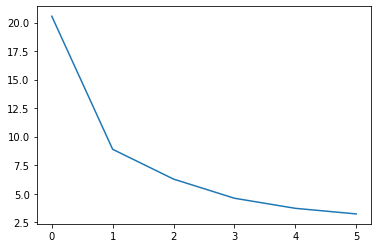

In [35]:
plt.plot(train_loss)

In [36]:
test_model(test_loader, model, simLoss=nn.MSELoss(), epoch=0)
#0.6727 - genomic, val :0.57286, 


0.6254893431926924


(4.525951226552327, 0.5063070900391474)

In [ ]:
for x, time, event, clinical_data, time_val in train_loader:
    break

In [45]:
input.shape

torch.Size([3, 5])

In [ ]:
kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
log_target = F.log_softmax(torch.rand(3, 5), dim=1)
>>> output = kl_loss(input, log_target)

In [50]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [54]:
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir

'logs/20240612-163257'

In [72]:
%tensorboard --logdir=runs


Reusing TensorBoard on port 6006 (pid 178758), started 0:01:53 ago. (Use '!kill 178758' to kill it.)

In [73]:
!kill 178758

In [ ]:
# Clinical + Genomic + WSI : Fusion Model
# Clinical + genomic : Fusion Model
# clinical 